# Visualization of country emissions using chorople maps and bubble charts

In [340]:
import pandas as pd
import numpy as np
import plotly.express as px
import geopandas as gpd
import matplotlib.pyplot as plt

## Load full country dataset

In [341]:
country_df = pd.read_parquet('../data/FAOSTAT/clean_data/all_tables_processed/full_country_dataset_v2_imputed.parquet')
country_df = country_df[country_df['Area Code'] <= 1000] #select countries only
country_df.sample(5)

,Area,Year,Area Code,Total_Energy_Emissions_(CO2)_kt,Total_Energy_Energy_use_in_agriculture_TJ,Cropland_organic_soils_Area_ha,Cropland_organic_soils_Emissions_(CO2)_kt,Cropland_organic_soils_Net_stock_change_(C)_kt,Drained_organic_soils_Area_ha,Drained_organic_soils_Emissions_(CO2)_kt,Drained_organic_soils_Net_stock_change_(C)_kt,Grassland_organic_soils_Area_ha,Grassland_organic_soils_Emissions_(CO2)_kt,Grassland_organic_soils_Net_stock_change_(C)_kt,Forestland_Area_1000_ha,Forestland_Net_emissions/removals_(CO2)_(Forest_land)_kt,Net_Forest_conversion_Area_1000_ha,Net_Forest_conversion_Net_emissions/removals_(CO2)_(Forest_land)_kt,Agrifood_Systems_Waste_Disposal_Emissions_(CO2eq)_(AR5)_kt_x,Energy_Use_(Pre-_and_Post-Production)_Emissions_(CO2eq)_(AR5)_kt,Energy_Use_(Pre-_and_Post-Production)_Energy_Use_(Total)_TJ,Fertilizers_Manufacturing_Emissions_(CO2eq)_(AR5)_kt_x,Food_Household_Consumption_Emissions_(CO2eq)_(AR5)_kt_x,Food_Household_Consumption_Energy_Use_(Total)_TJ,Food_Packaging_Emissions_(CO2eq)_(AR5)_kt_x,Food_Packaging_Energy_Use_(Total)_TJ,Food_Processing_Emissions_(CO2eq)_(AR5)_kt_x,Food_Processing_Energy_Use_(Total)_TJ,Food_Retail_Emissions_(CO2eq)_(AR5)_kt_x,Food_Retail_Energy_Use_(Total)_TJ,Food_Transport_Emissions_(CO2eq)_(AR5)_kt_x,Food_Transport_Energy_Use_(Total)_TJ,Pesticides_Manufacturing_Emissions_(CO2eq)_(AR5)_kt_x,Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt_x,Pre-_and_Post-_Production_Energy_Use_(Total)_TJ,Solid_Food_Waste_Emissions_(CO2eq)_(AR5)_kt,Agricultural_Soils_Emissions_(CO2eq)_(AR5)_kt,Agrifood_Systems_Waste_Disposal_Emissions_(CO2eq)_(AR5)_kt_y,Agrifood_systems_Emissions_(CO2eq)_(AR5)_kt,Burning_-_Crop_residues_Emissions_(CO2eq)_(AR5)_kt,Crop_Residues_Emissions_(CO2eq)_(AR5)_kt,Drained_organic_soils_Emissions_(CO2eq)_(AR5)_kt,Emissions_from_crops_Emissions_(CO2eq)_(AR5)_kt,Emissions_from_livestock_Emissions_(CO2eq)_(AR5)_kt,Emissions_on_agricultural_land_Emissions_(CO2eq)_(AR5)_kt,Enteric_Fermentation_Emissions_(CO2eq)_(AR5)_kt,Farm_gate_Emissions_(CO2eq)_(AR5)_kt,Fertilizers_Manufacturing_Emissions_(CO2eq)_(AR5)_kt_y,Fires_in_humid_tropical_forests_Emissions_(CO2eq)_(AR5)_kt,Fires_in_organic_soils_Emissions_(CO2eq)_(AR5)_kt,Food_Household_Consumption_Emissions_(CO2eq)_(AR5)_kt_y,Food_Packaging_Emissions_(CO2eq)_(AR5)_kt_y,Food_Processing_Emissions_(CO2eq)_(AR5)_kt_y,Food_Retail_Emissions_(CO2eq)_(AR5)_kt_y,Food_Transport_Emissions_(CO2eq)_(AR5)_kt_y,Forest_fires_Emissions_(CO2eq)_(AR5)_kt,Forestland_Emissions_(CO2eq)_(AR5)_kt,Land_Use_change_Emissions_(CO2eq)_(AR5)_kt,Manure_Management_Emissions_(CO2eq)_(AR5)_kt,Manure_applied_to_Soils_Emissions_(CO2eq)_(AR5)_kt,Manure_left_on_Pasture_Emissions_(CO2eq)_(AR5)_kt,Net_Forest_conversion_Emissions_(CO2eq)_(AR5)_kt,Pesticides_Manufacturing_Emissions_(CO2eq)_(AR5)_kt_y,Pre-_and_Post-_Production_Emissions_(CO2eq)_(AR5)_kt_y,Rice_Cultivation_Emissions_(CO2eq)_(AR5)_kt,Savanna_fires_Emissions_(CO2eq)_(AR5)_kt,Synthetic_Fertilizers_Emissions_(CO2eq)_(AR5)_kt,Waste_Emissions_(CO2eq)_(AR5)_kt,Country_area_Area_1000_ha,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No,Gross_Domestic_Product_Annual_growth_US$_per_capita_%,Gross_Domestic_Product_Value_US$_million_USD,Gross_Domestic_Product_Value_US$_per_capita_USD,Total_Energy_Emissions_(CH4_CO2eq)_kt,Total_Energy_Emissions_(N2O_CO2eq)_kt,Cropland_organic_soils_Emissions_(N2O_CO2eq)_kt,Drained_organic_soils_Emissions_(N2O_CO2eq)_kt,Grassland_organic_soils_Emissions_(N2O_CO2eq)_kt
5335,Mongolia,1981,141.0,71.8732,360.0000,104923.4703,3039.2832,828.8954,1.022705e+06,22220.9071,6060.2474,917781.0479,19181.6239,5231.3520,30012.48,-64.002,9.273,1281.8377,1419.371573,445.342534,3929.280126,NaN,142.978243,843.792126,NaN,NaN,NaN,NaN,151.257027,2846.088,189.392323,239.4,4.811798,1907.810963,3929.280126,1200.572393,2779.6380,1419.3716,20854.0485,15.4375,32.754,26419.7261,48.1915,11348.2334,40743.4816,7873.0624,39461.6439,NaN,0.0000,0.0,142.9782,0.0,0.0,151.2570,189.3923,153.5452,-64.002,1281.8377

## Load corrected country names compatible with geopandas

In [342]:
country_codes = pd.read_csv('../data/FAOSTAT/clean_data/fao_country_codes_corrected.csv')
country_codes.sample(5)

,Area Code,Area
30,38,Sri Lanka
27,34,Canton and Enderbury Islands
48,58,Ecuador
11,14,Barbados
55,66,Fiji


## Load world geometries.

### I need "iso_a3" codes to plot on map

In [343]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.sample(5)

C:\Users\UX433F\AppData\Local\Temp\ipykernel_21340\758265142.py:1: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



,pop_est,continent,name,iso_a3,gdp_md_est,geometry
121,83132799.0,Europe,Germany,DEU,3861123,"POLYGON ((14.11969 53.75703, 14.35332 53.24817..."
175,1394973.0,North America,Trinidad and Tobago,TTO,24269,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."
150,2087946.0,Europe,Slovenia,SVN,54174,"POLYGON ((13.80648 46.50931, 14.63247 46.43182..."
77,6855713.0,Asia,Lebanon,LBN,51991,"POLYGON ((35.82110 33.27743, 35.55280 33.26427..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."


## Merge country dataset with geopandas nomenclature

In [344]:
pd.set_option('display.max_rows', 100)
country_df = pd.merge(country_df.drop('Area', axis=1), country_codes, how='left', on='Area Code')
country_df[['Area Code', 'Area']].drop_duplicates().query('Area.isnull()').tail()

,Area Code,Area
10290,280.0,NaN
10332,281.0,NaN
10374,282.0,NaN
10416,283.0,NaN
10500,351.0,NaN


In [345]:
#Impute manually only "china". Has several regions and names.
#rest of missing country names are small islands, etc. I drop them for now.

country_df['Area'] = np.where(country_df['Area Code'] == 351, 'China', country_df['Area'])
country_df = country_df.dropna(subset=['Area'])

## Choropleth year 2021

In [346]:
# Define dummy target emissions column. After cleaning dataset, you can replace this with actual emissions data
target = 'Emissions_from_livestock_Emissions_(CO2eq)_(AR5)_kt'
year = 2021

In [347]:
df_2021 = country_df[country_df['Year'] == year][['Area', target]].dropna()
df_2021 = df_2021.groupby('Area').sum().reset_index()

In [348]:
# Merge the data with the world GeoDataFrame
world = world.merge(df_2021, how='left', left_on='name', right_on='Area').dropna()

### Map by country - total value

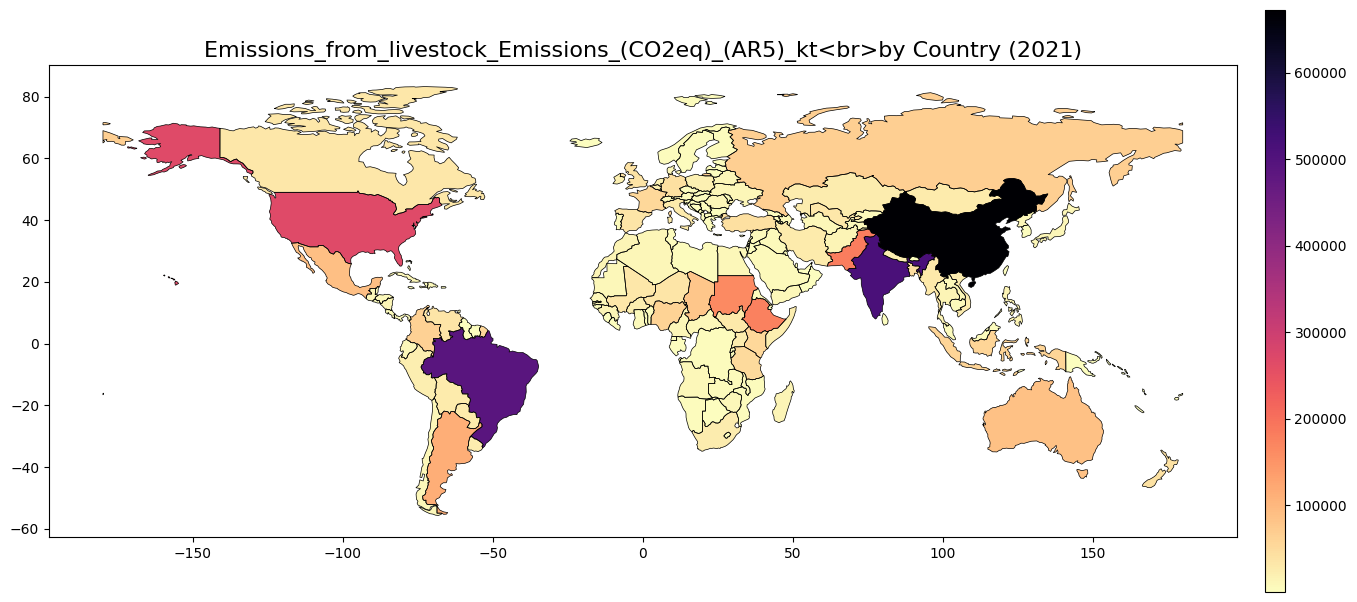

In [349]:
# Get the reversed magma color palette from Seaborn, same as for treemap plots
magma_palette_reversed = sns.color_palette("magma_r", as_cmap=True)

# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=magma_palette_reversed)

plt.title(f"{target}<br>by Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

### Map by country - per capita emissions

In [350]:
world[target] = world[target] / world['pop_est']  # per capita emissions

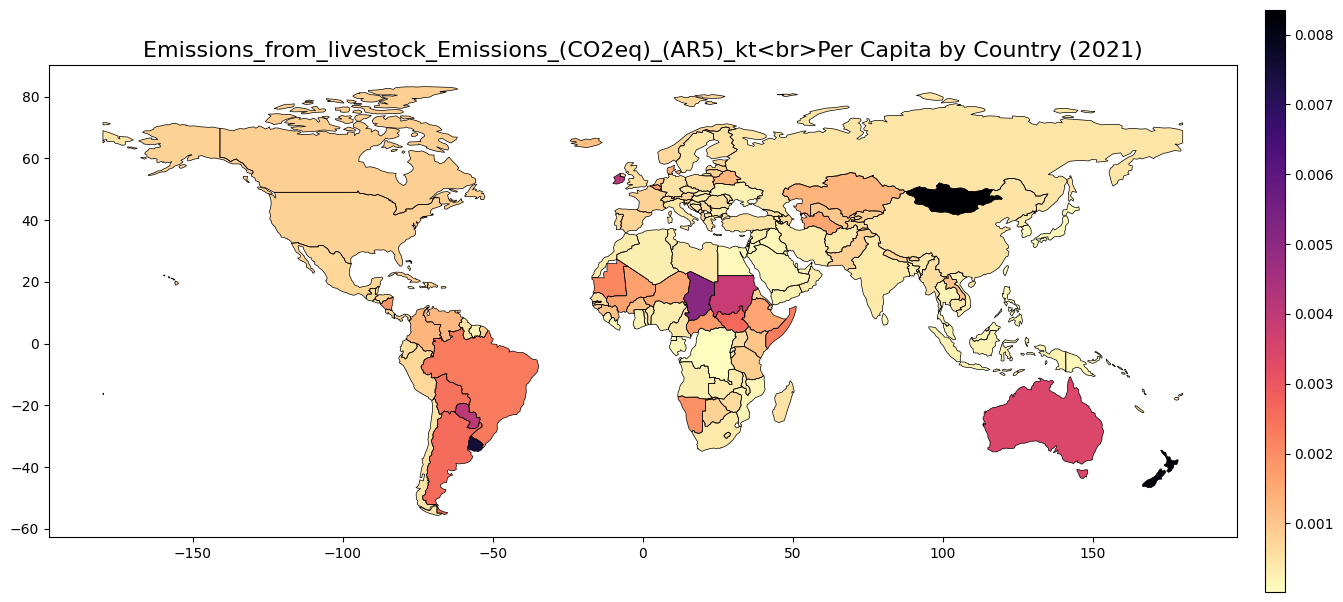

In [351]:
# Plot the map
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
world.boundary.plot(ax=ax, color='black', linewidth=0.5)

# Plot with custom legend parameters
plot = world.plot(column=target, ax=ax, legend=True,
                  legend_kwds={'orientation': "vertical",
                               'shrink': 0.6,  # Make colorbar smaller
                               'aspect': 30,   # Make colorbar thinner
                               'pad': 0.02},   # Adjust padding
                  cmap=magma_palette_reversed)

plt.title(f"{target}<br>Per Capita by Country ({year})", fontsize=16)
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()

# Interactive map with plotly express

In [352]:
df = country_df[['Year', 'Area', target]].dropna()
df = df.groupby(['Year', 'Area']).sum().reset_index()

# Merge the data with the world GeoDataFrame
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world_full = world.merge(df, how='left', left_on='name', right_on='Area').dropna()

C:\Users\UX433F\AppData\Local\Temp\ipykernel_21340\4220431971.py:5: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



### Total emissions by country over time

In [353]:
# Get the reversed magma color palette from Seaborn
magma_palette_reversed = sns.color_palette("magma_r", n_colors=256)

# Convert the Seaborn color palette to a format Plotly can use
magma_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in magma_palette_reversed]

# Calculate global min and max
vmin = world_full[target].min()
vmax = world_full[target].max()

# Plot the interactive choropleth map
fig = px.choropleth(
    world_full, 
    locations='iso_a3', 
    locationmode='ISO-3', 
    color=target, 
    hover_name='iso_a3', 
    animation_frame='Year',
    color_continuous_scale=magma_plotly,  # Use the custom color scale
    range_color=(vmin, vmax)  # Set the range of the color scale
)

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': f'{target}<br>by Country Over the Years',
        'x': 0.5,
        'xanchor': 'center'
    },
    coloraxis_colorbar=dict(
        title=""
    )
)

fig.write_html(f"../plots/{target}_TOTAL_map.html")
fig.show()

### Per capita emissions by country over time

In [354]:
world_full[target] = world_full[target] / world_full['pop_est']  # per capita emissions

In [355]:
# Get the reversed magma color palette from Seaborn
magma_palette_reversed = sns.color_palette("magma_r", n_colors=256)

# Convert the Seaborn color palette to a format Plotly can use
magma_plotly = [f'rgb({int(r*255)},{int(g*255)},{int(b*255)})' for r, g, b in magma_palette_reversed]

# Calculate global min and max
vmin = world_full[target].min()
vmax = world_full[target].max()

# Plot the interactive choropleth map
fig = px.choropleth(
    world_full, 
    locations='iso_a3', 
    locationmode='ISO-3', 
    color=target, 
    hover_name='iso_a3', 
    animation_frame='Year',
    color_continuous_scale=magma_plotly,  # Use the custom color scale
    range_color=(vmin, vmax)  # Set the range of the color scale
)

fig.update_layout(
    width=1000,
    height=600,
    title={
        'text': f'{target}<br>Per Capita by Country Over the Years',
        'x': 0.5,
        'xanchor': 'center'
    },
    coloraxis_colorbar=dict(
        title=""
    )
)

fig.write_html(f"../plots/{target}_percapita_map.html")
fig.show()

## Save to chart studio

In [356]:
import chart_studio 

username = "ezemriv"
password = "dmanBuRgSIAPjUFi4m1X"

chart_studio.tools.set_credentials_file(username=username, api_key=password)

import chart_studio.plotly as py
import chart_studio.tools as tls

In [357]:
py.plot(fig, filename = f'{target}_per_capita', auto_open=False)

'https://plotly.com/~ezemriv/11/'

# Map colored by clusters

Same but target should be "Clusters" column